In [ ]:
import torch
import torch.nn as nn

device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
import requests
import pathlib
from pathlib import Path
import kagglehub


path = kagglehub.dataset_download("antobenedetti/animals")

print("Path to dataset files:", path)

In [ ]:
data_path = Path("data/")
image_path = data_path / 'animals'

In [ ]:
import os

def walk_through_dir(dir_path):
    for dir_path, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dir_path}'.")
walk_through_dir(image_path)

In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

In [ ]:
import random
from PIL import Image

random.seed(42)


image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

data_transform = transforms.Compose([transforms.Resize(size=(64, 64)), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor()])

In [ ]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
    random.seed(42)
    random_image_paths = random.sample(image_paths, k= n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"ORIGINAL SIZE: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"TRANSFORMED SIZE: {transformed_image.shape}", fontsize = 10)
            ax[1].axis("off")

            fig.suptitle(f"CLASS: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)


In [ ]:
train_data = datasets.ImageFolder(root=train_dir, transform= data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform= data_transform)

print(f"TRAIN DATA: {train_data}, TEST DATA: {test_data}")

In [ ]:
class_names = train_data.classes
class_names

In [ ]:
class_dict = train_data.class_to_idx
class_dict

In [ ]:
len(train_data), len(test_data)

In [ ]:
img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, batch_size=10, num_workers= 2, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=10, num_workers=2, shuffle=False)

img, label = next(iter(train_dataloader))

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.TrivialAugmentWide(num_magnitude_bins=31), transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

### MODEL WITHOUT DATA AUGMENTATION

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader_simple = DataLoader(train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape : int, output_shape : int, hidden_units: 10):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape),
        )
    def forward(self, x : torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, output_shape= len(train_data.classes), hidden_units=10).to(device)

In [ ]:
img_batch, label_batch = next(iter(train_dataloader_simple))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

In [ ]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

In [ ]:
from helper_functions import accuracy_fn
def TrainStep(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device : torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        X,y = X.to(device), y.to(device)
        train_pred = model(X)
        loss = loss_fn(train_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_pred= train_pred.argmax(dim =1), y_true=y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"TRAIN LOSS: {train_loss} | TRAIN ACCURACY: {train_acc}")
    return train_loss, train_acc
def TestStep(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device : torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X,y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y_pred= test_pred.argmax(dim=1), y_true=y)
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"TEST LOSS: {test_loss} | TEST ACCURACY: {test_acc}")
    return test_loss, test_acc

In [92]:
from tqdm.auto import tqdm
writer = SummaryWriter()
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), epochs : int = 5):
    results = {"train_loss" : [], "test_loss" : [], "train_acc" : [], "test_acc" : []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = TrainStep(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn = accuracy_fn)
        test_loss, test_acc = TestStep(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        accuracy_fn = accuracy_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train_loss" : train_loss, "test_loss" : test_loss}, global_step=epoch)
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 64, 64).to(device))
    
    writer.close()
    
    return results

In [93]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_0_results = train(model=model_0, train_dataloader=train_dataloader_simple, test_dataloader=test_dataloader_simple, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

end_time = timer()
print(f"TOTAL TRAINING TIME: {int(end_time - start_time)} seconds on {device}")

  0%|          | 0/5 [00:00<?, ?it/s]

TRAIN LOSS: 1.6098904335668303 | TRAIN ACCURACY: 20.268068720379148
TEST LOSS: 1.6097056688146387 | TEST ACCURACY: 19.9468085106383
Epoch: 1 | train_loss: 1.6099 | train_acc: 20.2681 | test_loss: 1.6097 | test_acc: 19.9468


 20%|██        | 1/5 [00:59<03:59, 59.81s/it]

TRAIN LOSS: 1.609505224566889 | TRAIN ACCURACY: 20.134774881516588


 40%|████      | 2/5 [01:59<02:59, 59.91s/it]

TEST LOSS: 1.609490917084065 | TEST ACCURACY: 19.54787234042553
Epoch: 2 | train_loss: 1.6095 | train_acc: 20.1348 | test_loss: 1.6095 | test_acc: 19.5479
TRAIN LOSS: 1.6094051805717686 | TRAIN ACCURACY: 19.557168246445496
TEST LOSS: 1.6094550198697029 | TEST ACCURACY: 19.9468085106383
Epoch: 3 | train_loss: 1.6094 | train_acc: 19.5572 | test_loss: 1.6095 | test_acc: 19.9468


 60%|██████    | 3/5 [03:06<02:06, 63.13s/it]

TRAIN LOSS: 1.609333386353407 | TRAIN ACCURACY: 20.090343601895736


 80%|████████  | 4/5 [04:13<01:04, 64.37s/it]

TEST LOSS: 1.6094043381670688 | TEST ACCURACY: 19.9468085106383
Epoch: 4 | train_loss: 1.6093 | train_acc: 20.0903 | test_loss: 1.6094 | test_acc: 19.9468


 80%|████████  | 4/5 [04:40<01:10, 70.11s/it]


KeyboardInterrupt: 

In [34]:
model_0_results.keys()

dict_keys(['train_loss', 'test_loss', 'train_acc', 'test_acc'])

In [38]:
def plot_loss_curves(results : dict[str : list[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = 'train_loss')
    plt.plot(epochs, test_loss, label = 'test_loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = 'train_accuracy')
    plt.plot(epochs, test_accuracy, label = 'test_accuracy')
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.legend()

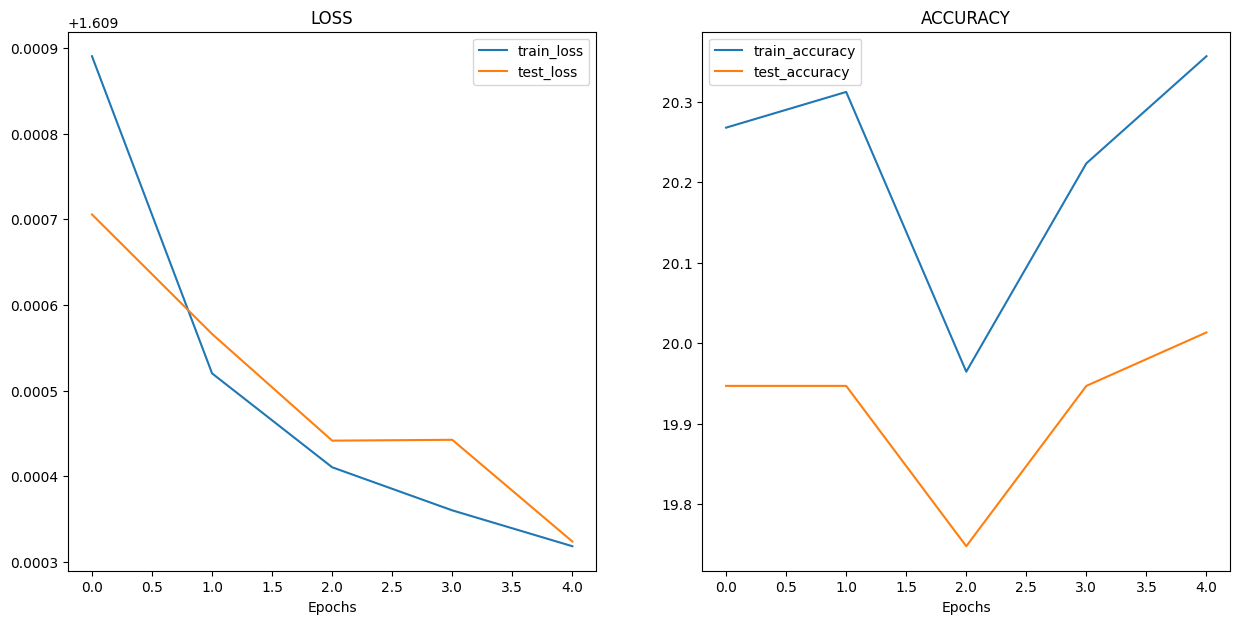

In [39]:
plot_loss_curves(model_0_results)

In [42]:
train_transform_trivial_argument = transforms.Compose([transforms.Resize((64, 64)), transforms.TrivialAugmentWide(num_magnitude_bins=31), transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

In [41]:
train_data_augmented = datasets.ImageFolder(train_dir, transform= train_transform_trivial_argument)
test_data_simple, train_data_augmented

(Dataset ImageFolder
     Number of datapoints: 1497
     Root location: data\animals\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 13474
     Root location: data\animals\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ))

In [43]:
torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, batch_size= BATCH_SIZE, num_workers= NUM_WORKERS, shuffle=True)
test_dataloader_simple, train_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x2b5fc066d70>,
 <torch.utils.data.dataloader.DataLoader at 0x2b5fc067ce0>)

In [44]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape= len(train_data_augmented.classes)).to(device)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)


start_time_model_1 = timer()

model_1_results = train(model=model_1, optimizer=optimizer, loss_fn=loss_fn, train_dataloader=train_dataloader_augmented, test_dataloader= test_dataloader_simple, epochs= NUM_EPOCHS)

end_time_model_1 = timer()

print(f"Total training time : {end_time_model_1 - start_time_model_1} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

TRAIN LOSS: 0.96562490418059 | TRAIN ACCURACY: 60.89306872037915


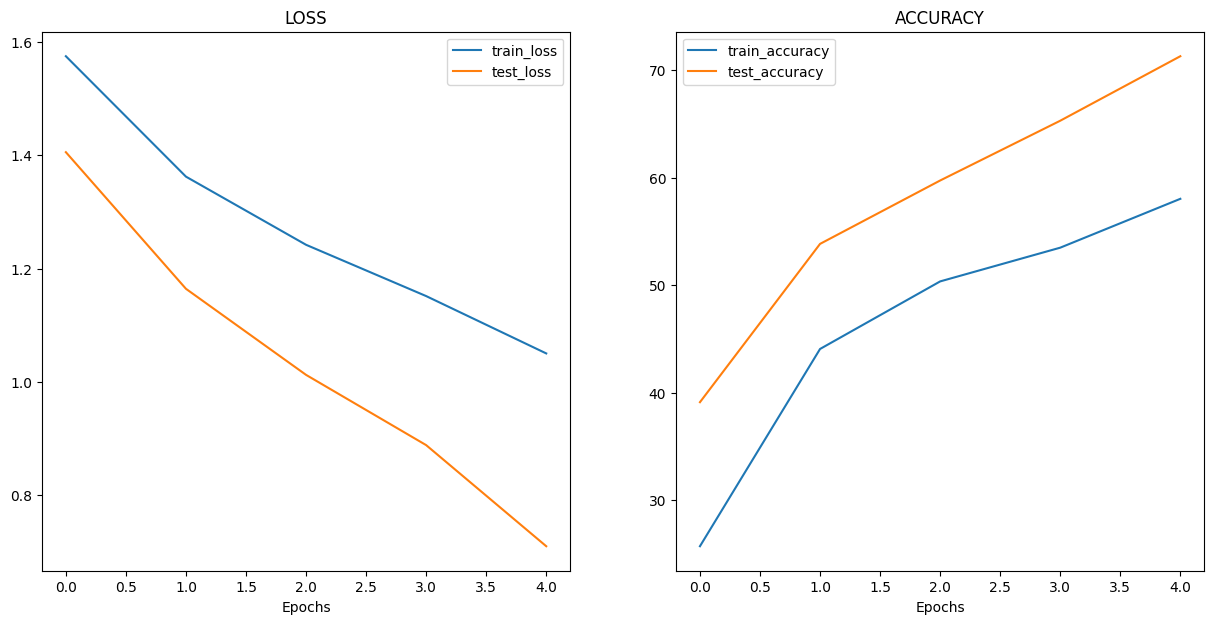

In [46]:
plot_loss_curves(results=model_1_results)

In [47]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,test_loss,train_acc,test_acc
0,1.609890,1.609706,20.268069,19.946809
1,1.609520,1.609566,20.312500,19.946809
2,1.609410,1.609441,19.964455,19.747340
3,1.609360,1.609442,20.223637,19.946809
4,1.609318,1.609324,20.356931,20.013298


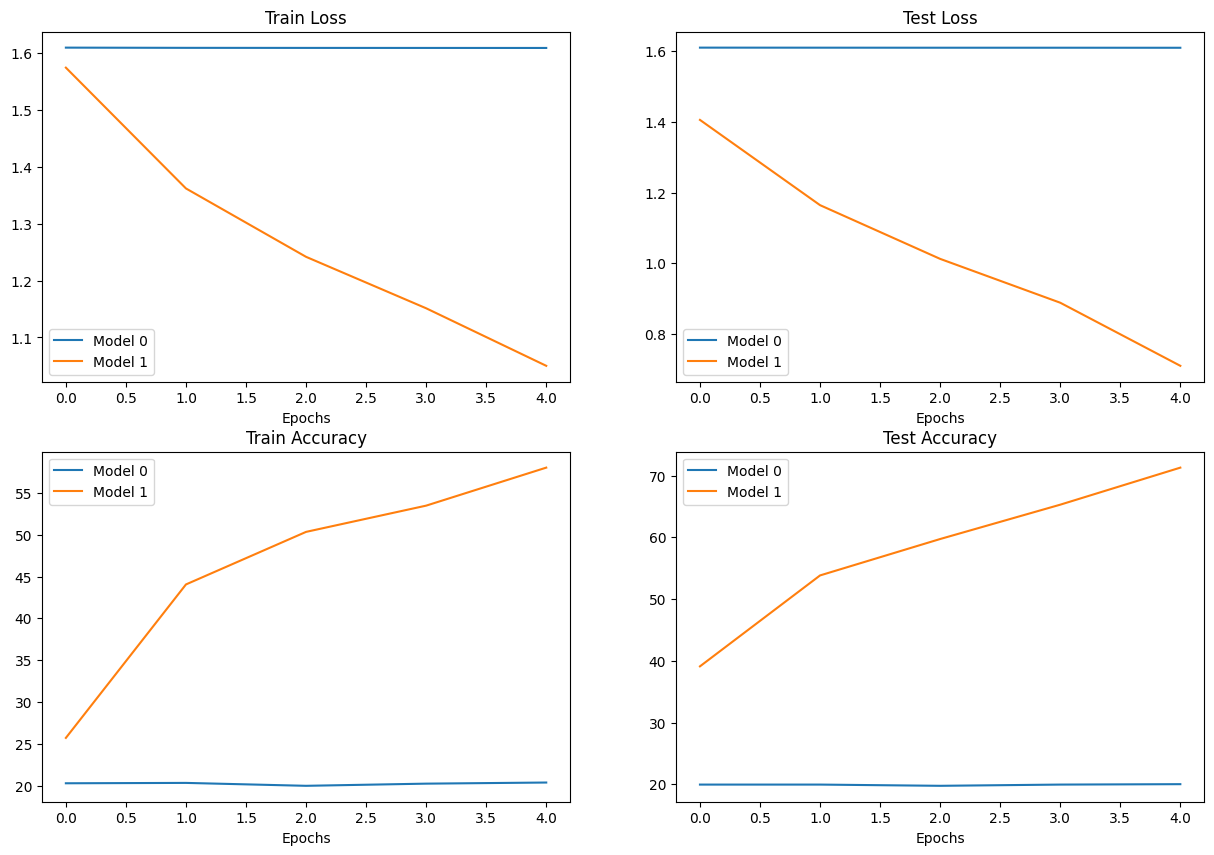

In [ ]:
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [79]:
custom_image_path = image_path / 'test' / 'cat' / 'cat2.jpg'

In [80]:
import torchvision

custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.4000, 0.4000, 0.4000,  ..., 0.3176, 0.3176, 0.3176],
         [0.4000, 0.4000, 0.4000,  ..., 0.3137, 0.3059, 0.3020],
         [0.4000, 0.3961, 0.3961,  ..., 0.2784, 0.2627, 0.2549],
         ...,
         [0.0000, 0.0196, 0.0196,  ..., 0.7098, 0.7490, 0.7686],
         [0.0000, 0.0196, 0.0196,  ..., 0.7098, 0.7451, 0.7608],
         [0.0000, 0.0196, 0.0196,  ..., 0.7176, 0.7373, 0.7529]],

        [[0.4588, 0.4588, 0.4588,  ..., 0.3608, 0.3608, 0.3608],
         [0.4588, 0.4588, 0.4588,  ..., 0.3490, 0.3412, 0.3373],
         [0.4588, 0.4549, 0.4549,  ..., 0.3059, 0.2941, 0.2863],
         ...,
         [0.0000, 0.0196, 0.0196,  ..., 0.6510, 0.6902, 0.7098],
         [0.0000, 0.0196, 0.0196,  ..., 0.6510, 0.6863, 0.7020],
         [0.0000, 0.0196, 0.0196,  ..., 0.6588, 0.6784, 0.6941]],

        [[0.5804, 0.5804, 0.5804,  ..., 0.4314, 0.4314, 0.4314],
         [0.5804, 0.5804, 0.5804,  ..., 0.4157, 0.4078, 0.4039],
         [0.5804, 0.5765, 0.5765,  ..

In [81]:
custom_image_transform = transforms.Compose([transforms.Resize((64, 64))])
custom_image_transformed = custom_image_transform(custom_image)
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")


Original shape: torch.Size([3, 512, 512])
New shape: torch.Size([3, 64, 64])


In [82]:
model_1.eval()
with torch.inference_mode():
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [83]:
custom_image_probs = torch.softmax(custom_image_pred, dim = 1)
custom_image_label = torch.argmax(custom_image_probs, dim = 1)
custom_image_class = class_names[custom_image_label.to('cpu')]
custom_image_class

'cat'

### PREDICTING AND PLOTTING THE IMAGE

In [84]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: list[str],
    transform: torchvision.transforms.Compose,
    device: torch.device = device,
):
    
    target_image = Image.open(image_path)
    target_image_transformed = transform(target_image)
    target_image_transformed_with_batch = target_image_transformed.unsqueeze(dim=0)

    model.eval()
    with torch.inference_mode():
        target_image_tensor = target_image_transformed_with_batch.to(device)
        pred_logits = model(target_image_tensor)
        
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_label = torch.argmax(pred_probs, dim=1)
    
    plt.imshow(target_image_transformed.permute(1, 2, 0)) 
    
    title = f"Pred: {class_names[pred_label.item()]} | Prob: {pred_probs.max().item():.3f}"
    plt.title(title)
    plt.axis(False) 
    plt.show()

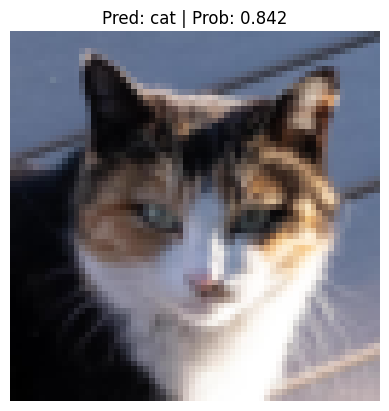

In [85]:
custom_image_tensor_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_tensor_transform,
                    device=device)

In [ ]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard 
    from torch.utils.tensorboard import SummaryWriter